# Kats 201 - Forecasting with Kats

Kats stands for kits to analyze time series, a light-weight, easy-to-use, extenable, and generalizable framework to perform time series analysis. Time series analysis is an essential component of data science and engineering works in the industry, such as understanding the key statistics and characteristics, detecting anomalies and change points, to forecasting future trends and extract meaningful features. Kats aims to provide the one-stop shop for time series analysis, including detection, forecasting, feature extraction, multivariate analysis, etc.

We provide two types of tutorial notebooks

- **Kats 101**, basic data structure and functionalities in Kats (this tutorial)
- **Kats 20x**, advanced topics, such as advanced forecasting techniques (meta-learning, global model, etc.), advanced detection algorithms (Bayesian online change point detection algorithms, etc), and more.

In this tutorial, we will introduce how to perform time series modeling and forecasting with Kats. We will cover the following:
* How to create time series forecasts with Kats via various models
* How to do parameter tuning using Kats
* How to do backtesting using Kats

# 1. Forecasting with Kats models

In this part, we will demonstrate the forecasting workflow with basic statistical models `ARIMA/SARIMA`, `Prophet`, `Holt-Winters`, and `Ensemble` models, with `air_passengers` data set.

In [3]:
import pandas as pd
import numpy as np
import sys
sys.path.append("../")

from kats.consts import TimeSeriesData
air_passengers_df = pd.read_csv("../kats/data/air_passengers.csv")

# Note: If the column holding the time values is not called time, you will want to specify the name of this column.
air_passengers_df.columns = ["time", "value"]
air_passengers_ts = TimeSeriesData(air_passengers_df)

## ARIMA/SARIMA

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


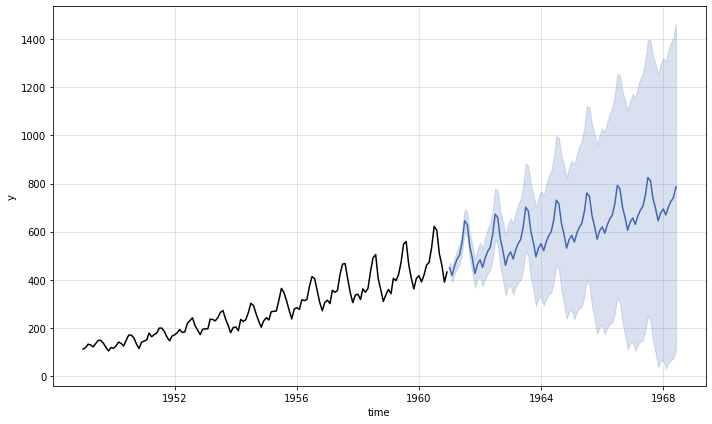

In [14]:
from kats.models.sarima import SARIMAModel, SARIMAParams

# create SARIMA param class
params = SARIMAParams(
    p = 2, 
    d=1, 
    q=1, 
    trend = 'ct', 
    seasonal_order=(1,0,1,12)
    )

# initiate SARIMA model
m = SARIMAModel(data=air_passengers_ts, params=params)

# fit SARIMA model
m.fit()

# generate forecast values
fcst = m.predict(
    steps=90, 
    freq="MS"
    )

# make plot to visualize
m.plot()

## Prophet

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


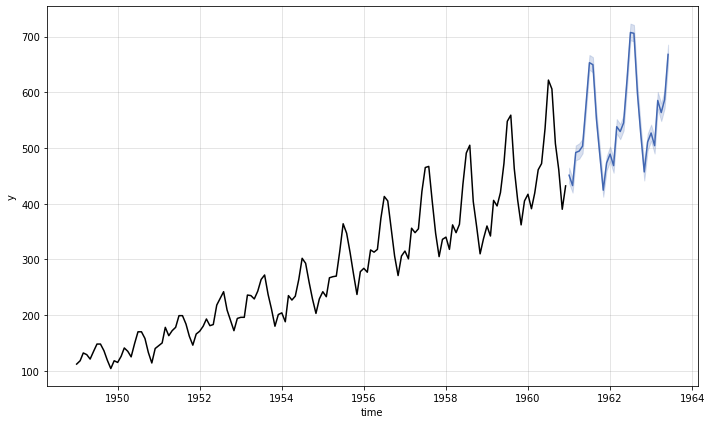

In [4]:
# import the param and model classes for Prophet model
from kats.models.prophet import ProphetModel, ProphetParams

# create a model param instance
params = ProphetParams(seasonality_mode='multiplicative') # additive mode gives worse results

# create a prophet model instance
m = ProphetModel(air_passengers_ts, params)

# fit model simply by calling m.fit()
m.fit()

# make prediction for next 30 month
fcst = m.predict(steps=30, freq="MS")

# plot to visualize
m.plot()

## Holt-Winters

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Che

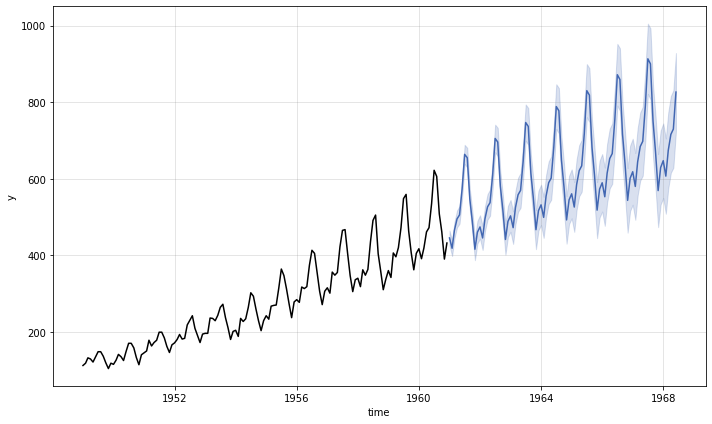

In [18]:
from kats.models.holtwinters import HoltWintersParams, HoltWintersModel

params = HoltWintersParams(
            trend="add",
            damped=False,
            seasonal="mul",
            seasonal_periods=12,
        )
m = HoltWintersModel(
    data=air_passengers_ts, 
    params=params)

m.fit()
fcst = m.predict(steps=90, alpha = 0.1)
m.plot()

## Ensemble model

We also provided an ensemble forecasting model. It starts from seasonality detection, if seasonality detected, it continues to perform STL decomposition, then fit forecasting models on de-seasonalized components and aggregate; otherwise it simiply leverage individual forecasting models and ensembling. We provided two ensembling methods, weighted average and median ensembling.

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
../kats/models/theta.py:115: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N ar

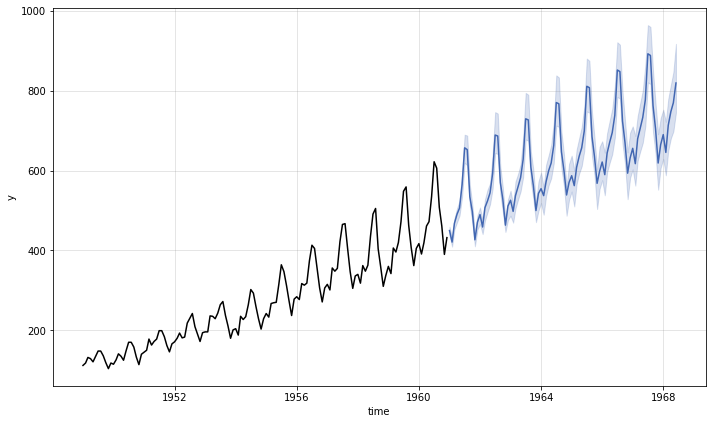

In [2]:
from kats.models.ensemble.ensemble import EnsembleParams, BaseModelParams
from kats.models.ensemble.kats_ensemble import KatsEnsemble
from kats.models import (
    arima,
    holtwinters,
    linear_model,
    prophet,
    quadratic_model,
    sarima,
    theta,
)

# we need define params for each individual forecasting model in `EnsembleParams` class
model_params = EnsembleParams(
            [
                BaseModelParams("arima", arima.ARIMAParams(p=1, d=1, q=1)),
                BaseModelParams(
                    "sarima",
                    sarima.SARIMAParams(
                        p=2,
                        d=1,
                        q=1,
                        trend="ct",
                        seasonal_order=(1, 0, 1, 12),
                        enforce_invertibility=False,
                        enforce_stationarity=False,
                    ),
                ),
                BaseModelParams("prophet", prophet.ProphetParams()),
                BaseModelParams("linear", linear_model.LinearModelParams()),
                BaseModelParams("quadratic", quadratic_model.QuadraticModelParams()),
                BaseModelParams("theta", theta.ThetaParams(m=12)),
            ]
        )

# create `KatsEnsembleParam` with detailed configurations 
KatsEnsembleParam = {
    "models": model_params,
    "aggregation": "median",
    "seasonality_length": 12,
    "decomposition_method": "multiplicative",
}

# create `KatsEnsemble` model
m = KatsEnsemble(
    data=air_passengers_ts, 
    params=KatsEnsembleParam
    )

# fit and predict
m.fit()

# predict for the next 90 steps
fcst = m.predict(steps=90)

# aggregate individual model results
m.aggregate()

# plot to visualize
m.plot()

## Multivariate model

In [3]:
multi_df = pd.read_csv("../kats/data/multi_ts.csv")
multi_ts = TimeSeriesData(multi_df)

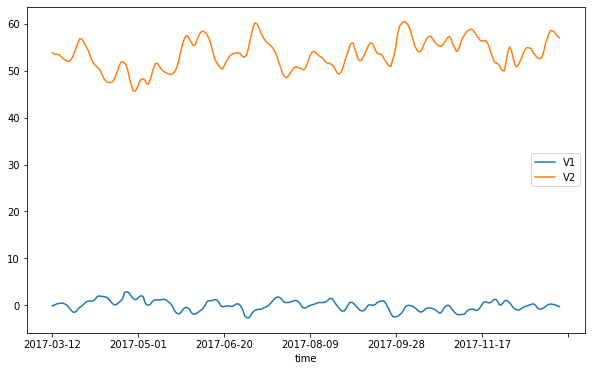

In [5]:
multi_df.groupby('time').sum()[['V1', 'V2']].plot(figsize=(10, 6))

In [19]:
# Use VAR model to forecast this multivariate time series
from kats.models.var import VARModel, VARParams

params = VARParams()
m = VARModel(multi_ts, params)
m.fit()
fcst = m.predict(steps=90)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


## Hyperparameter tuning

To identify which hyperparameters to use for a given model, we have the HyperParameter tuning class in Kats which can efficiently identify the best hyperparameter to use. Below we demonstrate an example of tuning the hyperparameters for an ARIMA model with a Grid Search technique. 

In [3]:
import kats.parameter_tuning.time_series_parameter_tuning as tpt
from kats.consts import ModelEnum, SearchMethodEnum, TimeSeriesData
from kats.models.arima import ARIMAParams, ARIMAModel

from ax.core.parameter import ChoiceParameter, FixedParameter, ParameterType
from ax.models.random.sobol import SobolGenerator
from ax.models.random.uniform import UniformGenerator

In [4]:
split = len(air_passengers_df) - int(0.2*len(air_passengers_df))
train, test = air_passengers_df[0:split], air_passengers_df[split:]

train_ts = TimeSeriesData(train)
test_ts = TimeSeriesData(test)

def evaluation_function(params):
    arima_params = ARIMAParams(
        p = params['p'],
        d = params['d'],
        q = params['q']
    )
    model = ARIMAModel(train_ts, arima_params)
    model.fit()
    model_pred = model.predict(steps=len(test))
    error = np.mean(np.abs(model_pred['fcst'].values - test_ts.value.values))
    return error

parameters_grid_search = [
{
    "name": "p",
    "type": "choice",
    "values": list(range(1, 3)),
    "value_type": "int",
    "is_ordered": True,
},
{
    "name": "d",
    "type": "choice",
    "values": list(range(1, 3)),
    "value_type": "int",
    "is_ordered": True,
},
{
    "name": "q",
    "type": "choice",
    "values": list(range(1, 3)),
    "value_type": "int",
    "is_ordered": True,
},
]

In [5]:
parameter_tuner_grid = tpt.SearchMethodFactory.create_search_method(
    objective_name="evaluation_metric",
    parameters=parameters_grid_search,
    selected_search_method=SearchMethodEnum.GRID_SEARCH,
)

In [8]:
parameter_tuner_grid.generate_evaluate_new_parameter_values(
    evaluation_function=evaluation_function, arm_count=-1
)

# Retrieve parameter tuning results

parameter_tuning_results_grid = (
    parameter_tuner_grid.list_parameter_value_scores()
)

parameter_tuning_results_grid

/Users/iamxiaodong/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


/Users/iamxiaodong/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.


,arm_name,metric_name,mean,sem,trial_index,parameters
0,0_0,evaluation_metric,119.194690,0.0,1,"{'p': 1, 'd': 1, 'q': 1}"
1,0_1,evaluation_metric,59.204497,0.0,1,"{'p': 1, 'd': 1, 'q': 2}"
2,0_2,evaluation_metric,180.281288,0.0,1,"{'p': 1, 'd': 2, 'q': 1}"
3,0_3,evaluation_metric,165.261076,0.0,1,"{'p': 1, 'd': 2, 'q': 2}"
4,0_4,evaluation_metric,54.857581,0.0,1,"{'p': 2, 'd': 1, 'q': 1}"
5,0_5,evaluation_metric,61.143930,0.0,1,"{'p': 2, 'd': 1, 'q': 2}"
6,0_6,evaluation_metric,158.840926,0.0,1,"{'p': 2, 'd': 2, 'q': 1}"
7,0_7,evaluation_metric,167.438206,0.0,1,"{'p': 2, 'd': 2, 'q': 2}"


So we concluded that ARIMA(2,1,1) has the minimal error of 54.8

## Backtesting

We also have a backtesting module which can make it easy to evaluate different forecasting algorithms. Here we demonstrate a simple backtesting using the ARIMA model and the Prophet model

In [11]:
from kats.utils.backtesters import BackTesterSimple
from kats.models.arima import ARIMAModel, ARIMAParams


backtester_errors = {}
params = ARIMAParams(p=2, d=1, q=1)
ALL_ERRORS = ['mape', 'smape', 'mae', 'mase', 'mse', 'rmse']

backtester = BackTesterSimple(
    ALL_ERRORS,
    air_passengers_ts,
    params,
    75,25, ARIMAModel)

backtester.run_backtest()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [12]:
backtester_errors['arima'] = {}
for error, value in backtester.errors.items():
    backtester_errors['arima'][error] = value

In [13]:
params_prophet = ProphetParams(seasonality_mode='multiplicative') # additive mode gives worse results

backtester_prophet = BackTesterSimple(
    ALL_ERRORS,
    air_passengers_ts,
    params_prophet,
    75,25, ProphetModel)

backtester_prophet.run_backtest()

backtester_errors['prophet'] = {}
for error, value in backtester_prophet.errors.items():
    backtester_errors['prophet'][error] = value

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [14]:
pd.DataFrame.from_dict(backtester_errors)

,arima,prophet
mape,0.120352,0.073343
smape,0.124585,0.069898
mae,54.349118,29.219968
mase,2.674957,1.438149
mse,5052.721874,1103.835150
rmse,71.082500,33.224015
